<a href="https://colab.research.google.com/github/shawk17/563-shawk17/blob/main/Project_1_offlattice_mc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Code

$$V_{LJ} = 4ϵ[(\frac{σ}{r})^{12} - (\frac{σ}{r})^6]$$

In [2]:
#HW4
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import combinations, product
import copy
import math

NA = 6.022E23 # Avogadro's number
R = 8.314472 # J/K/mol

class Particle():
  def __init__(self,L, dim=3, id = 1):
    loc = np.random.rand(dim)*L
    self.location = np.array(loc)
    self.id = id

  def __repr__(self):
    return f'{self.id}'

In [5]:
class Volume():
  def __init__(self,N=5,L=4,T=1.0, epsilon=1, sigma = 1, m = 40,dim=3, rcut=2.5):
    self.rcut = rcut*sigma
    self.L = L
    self.N = N
    self.epsilon = epsilon
    self.T = T
    self.sigma = sigma
    self.m = m
    self.dim = dim

    self.particles = []
    for i in range(self.N):
      p = Particle(L, dim=dim, id = i)
      self.particles.append(p)


    self.particle_pairs = list(combinations(self.particles, 2))
    self.E = self.energy()
    self.m = m
    self.V = self.L**3

  def energy(self):
    energy = 0
    for pair in self.particle_pairs:
      energy += self.LJ(pair[0].location, pair[1].location)
    return energy

  def particle_energy(self, p):
    energy = 0
    for particle in self.particles:
      if not p == particle:
        energy += self.LJ(particle.location, p.location)
    return energy

  def position_energy(self, pos, p=None):
    energy = 0
    for particle in self.particles:
      if not p == particle:
        energy += self.LJ(particle.location, pos)
    return energy

  def LJ(self, site1, site2):
    delta = site1 - site2
    delta -= self.L * np.round(delta / self.L)  # Minimum image convention
    r = np.linalg.norm(delta)
    if r > self.rcut:
      return 0

    r /= self.sigma

    if r == 0:  # Avoid division by zero
        return 0
    # Compute potential energy
    U = 4 * self.epsilon * (1/r**12 - 1/r**6)

    return U

In [3]:
# Simulation class
class Simulation():
  def __init__(self,move=0.1,N=5,L=3,T=1.,seed=2, verbose = True, **kwargs):
    np.random.seed(seed)
    self.volume = Volume(N,L,T, **kwargs)
    self.volume.E = self.volume.E
    self.move = move
    self.accepted = 0
    self.rejected = 0
    self.steps = 0
    self.pressures = []
    self.energies = []
    self.verbose = verbose

  def __repr__(self):
    return f'Vol: {self.volume.V:.3g}, accept: {self.accepted}, reject {self.rejected}, steps: {self.steps}'

  def trial_move(self):
    p = np.random.choice(self.volume.particles)
    dr = np.random.uniform(-self.move, self.move, len(p.location))
    new_pos = (p.location + dr) % self.volume.L # Apply periodic boundaries

    poldE = self.volume.particle_energy(p)
    pnewE = self.volume.position_energy(new_pos, p=p)
    dE = pnewE - poldE

    self.steps += 1
    if dE < 0 or np.random.rand() < np.exp(-dE/self.volume.T):
      p.location = new_pos
      self.volume.E += dE
      self.accepted += 1
      return
    else:
      self.rejected += 1
      return

  def run(self, steps, move_gradient = None, max_time = 300, keep_loc = False):
    gradient=False
    self.particle_locs = []

    if not move_gradient is None:
      gradient = True
      move_gradient = np.linspace(move_gradient[0], move_gradient[1], steps)

    t1 = time.perf_counter()
    if self.verbose:
      print(f'The number of particles is {self.volume.N}')
      print(f'Starting per particle energy {self.volume.E/self.volume.N:.4g}')

    for i in range(steps):
      self.trial_move()
      self.energies.append(self.volume.E/self.volume.N)
      if gradient:
        self.move = move_gradient[i]
      if time.perf_counter() - t1 > max_time:
        print(f'Reached max time of {max_time} seconds')
        break
      if keep_loc:
        self.particle_locs.append(copy.deepcopy(self.volume.particles))
    t2 = time.perf_counter()
    if self.verbose:
      print(f'Ran {steps} in {t2-t1:.5g} seconds')
      print(f'Acceptance: {self.accepted/steps};    Rejection: {self.rejected/steps}')
      print(f'Ending per particle energy {self.volume.E/self.volume.N:.4g}')
    return t2 - t1

In [9]:
# N/V = 0.5
kb = 1.380649E-23 # J/K
simulations = []
durations = []
Cvs = []

step = 5000
T = 1
N = 50
rho = 0.5
L = (N / rho)**(1/3)
print(L)
pressure_steps = 1000

sim = Simulation(move=0.1, N=N, L=L, T=T, epsilon=1,
                  sigma=1, m=1, dim=3, verbose=True, seed = 2)
sim.run(step, move_gradient = None)


4.641588833612778
The number of particles is 50
Starting per particle energy 6.378e+11
Ran 5000 in 6.9873 seconds
Acceptance: 0.6524;    Rejection: 0.3476
Ending per particle energy -3.198


6.987342596000019

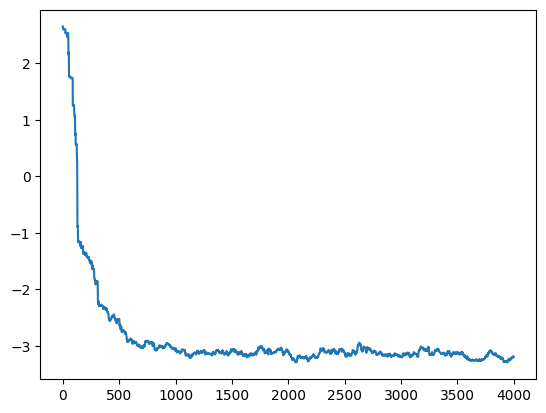

In [10]:
plot_amount = 1000
plt.plot(sim.energies[plot_amount:])
plt.show()

1. Pick a physical system you’re curious about (e.g., Argon, Methane, Lennard-Jonesium, ethane, etc).
  * I am doing argon as a LJ systme, ϵ/kb=120 K, σ=0.34nm, and m=40d
1. Determine a representation of it that balances ease of implementation with probing its thermodynamics.
  * Reduced units, LJ potential, PBC, I am not doing any tail corrections, I am considering every particle interaction, (no truncation).
  * I added Verlet boxes, this works well for larger system sizes, but for the 50 particles I was considering it didn't help at all, it actually hurt. I put in a check to make sure the cutoff was large enough, so it didn't start double counting particles.
1. Characterize your model’s performance:
  1. How long does it take to equilibrate at extremes of state (high densities, low temperatures)?
    * With high densities, low temp it takes (around the supposed freezing point, and density) 50 particles about 5000 steps to equilibrate, however, I didn't not see a pressure drop arround that point.
  2. How small is too small? How big is too big?
    * For Google Colab, I predict can do about 1000 particles for 5000 steps in 5 minutes, as it seems to be scaling roughly linearly. It with particles, it seems like it should scale faster than this though.
1. Contrast your system with an ideal gas:
  1. How does the structure of your model vary with state, and how does it compare to particles with no interactions?
    * My model seems to almost perfectly follow the ideal gas law, at least at changing only volume, only temperature, or only number.
  1. Does the heat capacity of your system depend on state differently than an ideal gas?
    * Currently yes, but it shouldn't, I can't figure out why. At least it shouldn't arround the freezing and melting points.
    * Running the systems for longer seems to get it closer to an ideal gas, I am wondering if I wasn't letting it equilibrate.
  1. Can you derive or numerically determine an equation of state?
    * Yes, I could, see below, it is nearly indistinguishable from an ideal gas.
1. Summarize where your model works well to give insight, where it breaks down, and any revelations that occurred while working towards 1-4.
  * My model works well when simulating an ideal gas, it doesn't predict freezing or melting points, at least not at the system sizes I tried.
  * I am still uncertain why my heat capcity is so off, I tried for hours to figure that out. I think my equations right, but I'll need some help.
  * It equilibrates to pressure surprisingly quickly, way faster than it equilibrates to energy. Why is that?
  * If I had more time I would look more closely at the melting and freezing points to see if I could actually get a prediction for those.
